# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [22]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [23]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [48]:
indices

[5666,
 58108,
 63611,
 30267,
 19092,
 46306,
 38510,
 67660,
 6846,
 3070,
 71765,
 59243,
 9366,
 32931,
 17877,
 25217,
 478,
 44063,
 50585,
 61416,
 44342,
 56000,
 9431,
 26009,
 33810,
 1261,
 48808,
 46881,
 22182,
 6229,
 51261,
 8032,
 23097,
 41497,
 23509,
 64526,
 3782,
 30345,
 18859,
 36159,
 29651,
 4916,
 37642,
 20766,
 28014,
 66118,
 58006,
 26137,
 15041,
 54750,
 48567,
 21728,
 27054,
 72461,
 3163,
 31850,
 59761,
 24436,
 49679,
 67981,
 20043,
 58094,
 43267,
 56510,
 40299,
 44944,
 67390,
 32477,
 44569,
 9571,
 14638,
 37685,
 26591,
 8830,
 13878,
 10368,
 61841,
 69653,
 36458,
 12599,
 23597,
 68305,
 1800,
 23290,
 7786,
 2878,
 73089,
 674,
 8069,
 35288,
 61331,
 45184,
 27291,
 64254,
 34145,
 62571,
 15707,
 40486,
 19475,
 43679,
 72291,
 70755,
 3678,
 15661,
 66949,
 17774,
 18460,
 31006,
 50847,
 58720,
 23985,
 46668,
 14124,
 51740,
 18808,
 48925,
 26903,
 26402,
 462,
 46929,
 35545,
 46878,
 14604,
 48699,
 21047,
 48932,
 62485,
 16993,


В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [24]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [43]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [76]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        scheduler.step()
            
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    # Hint: PyTorch has the argmax function!
    
    #raise Exception("Not implemented")
    
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 0.757692, Train accuracy: 0.775501, Val accuracy: 0.786977
Average loss: 0.737404, Train accuracy: 0.779528, Val accuracy: 0.788956
Average loss: 0.691740, Train accuracy: 0.793946, Val accuracy: 0.804723


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [46]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.186410, Train accuracy: 0.199502, Val accuracy: 0.233022
Average loss: 2.007701, Train accuracy: 0.271133, Val accuracy: 0.313084
Average loss: 1.848615, Train accuracy: 0.348906, Val accuracy: 0.371374
Average loss: 1.765630, Train accuracy: 0.395762, Val accuracy: 0.408846
Average loss: 1.724290, Train accuracy: 0.415845, Val accuracy: 0.418606


Добавьте слой с Batch Normalization

In [32]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.225987, Train accuracy: 0.227622, Val accuracy: 0.334721
Average loss: 2.064914, Train accuracy: 0.365372, Val accuracy: 0.387277
Average loss: 1.956563, Train accuracy: 0.397570, Val accuracy: 0.423521
Average loss: 1.875551, Train accuracy: 0.430383, Val accuracy: 0.446727
Average loss: 1.814750, Train accuracy: 0.455107, Val accuracy: 0.457102


Добавьте уменьшение скорости обучения по ходу тренировки.

In [91]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=0)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.730176, Train accuracy: 0.443470, Val accuracy: 0.554501
Average loss: 1.223877, Train accuracy: 0.631949, Val accuracy: 0.686711
Average loss: 0.983118, Train accuracy: 0.709979, Val accuracy: 0.714286
Average loss: 0.905386, Train accuracy: 0.729567, Val accuracy: 0.754761
Average loss: 0.809728, Train accuracy: 0.758745, Val accuracy: 0.777421


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [74]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    loader = torch.utils.data.DataLoader(data_train, batch_size=64, sampler=SubsetSampler(indices))
    p = []
    gt = []
    for i_step, (x,y) in enumerate(loader):
        pred = model(x)
        p.append(torch.argmax(pred, 1))
        gt.append(y)
    print('p:', len(p))
    #raise Exception("Not implemented")
    predictions = np.concatenate((p))
    print('predictions:', predictions.shape)
    ground_truth = np.concatenate((gt))
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

p: 229
predictions: (14651,)


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

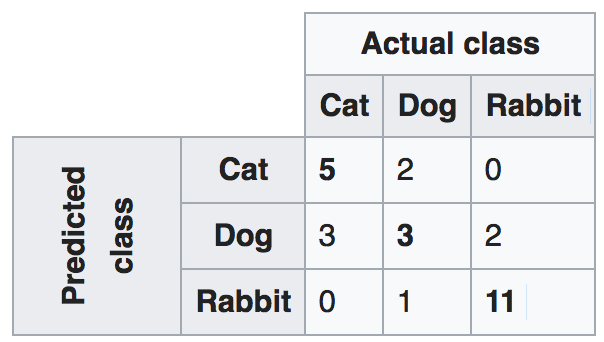

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

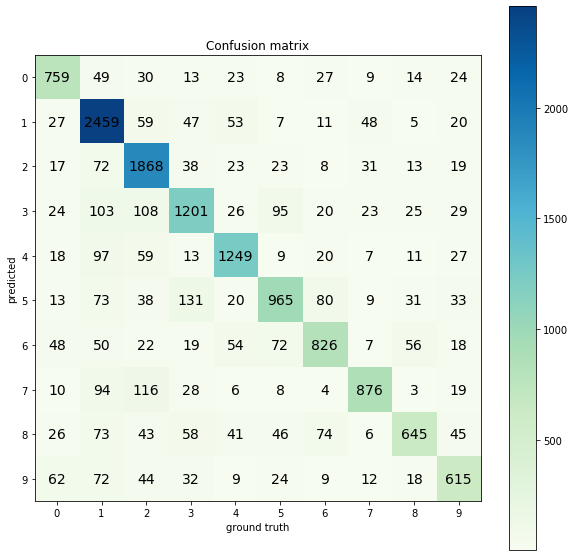

In [92]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for i in range(10):
        for j in range(10):
            p = np.where(predictions==j)
            g = np.where(ground_truth==i)
            confusion_matrix[i,j] = len(np.intersect1d(p,g))
    return confusion_matrix#np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [88]:
a = np.where(np.array([10,9,8,7,7])==7)
b = np.where(np.array([7,7,8,9,7])==7)
print(a,b)

(array([3, 4]),) (array([0, 1, 4]),)


Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

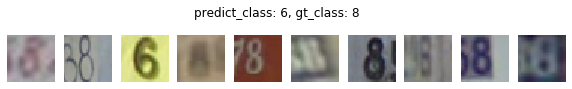

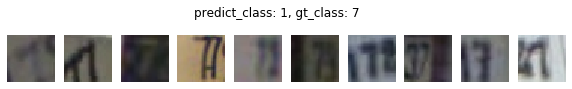

In [105]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    
    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    p = np.where(predictions==predicted_class)
    g = np.where(ground_truth==gt_class)
    indices = val_indices[np.intersect1d(p, g)]
    visualize_images(indices, data, title='predict_class: '+str(predicted_class)+', gt_class: '+str(gt_class))
    #raise Exception("Not implemented")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [96]:
# Experiment here!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
optimizer = optim.Adam(nn_model.parameters(), lr=1e-2, weight_decay=1e-7)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 7)

Average loss: 1.393934, Train accuracy: 0.536447, Val accuracy: 0.687120
Average loss: 0.998400, Train accuracy: 0.689298, Val accuracy: 0.737970
Average loss: 0.828628, Train accuracy: 0.742723, Val accuracy: 0.775305
Average loss: 0.774053, Train accuracy: 0.759018, Val accuracy: 0.784588
Average loss: 0.702944, Train accuracy: 0.782343, Val accuracy: 0.796055
Average loss: 0.679844, Train accuracy: 0.790482, Val accuracy: 0.804518
Average loss: 0.641989, Train accuracy: 0.802136, Val accuracy: 0.814347


In [98]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 0.627796, Train accuracy: 0.806795, Val accuracy: 0.814142
Average loss: 0.625070, Train accuracy: 0.807511, Val accuracy: 0.814757
Average loss: 0.601409, Train accuracy: 0.815138, Val accuracy: 0.821173


In [99]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7884
